### Imports Needed For EDA

In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Making CSV files for Each Relevent Feature (Do not run anymore, we saved the files)


In [60]:
base_dir = "stress_dataset/Data"
exams = ["Final", "Midterm 1", "Midterm 2"]
eda_rows, hr_rows, temp_rows, acc_rows,ibi_rows = [], [], [], [],[]

for subj in os.listdir(base_dir):
    subj_path = os.path.join(base_dir, subj)
    if not subj.startswith("S") or not os.path.isdir(subj_path):
        continue
    for exam in exams:
        exam_dir = os.path.join(base_dir, subj, exam)

        with open(os.path.join(exam_dir, "EDA.csv")) as f:
            start = float(f.readline().strip())
            freq = float(f.readline().strip())
        eda = pd.read_csv(os.path.join(exam_dir, "EDA.csv"), skiprows=2, header=None, names=["value"])
        eda["timestamp"] = [start + i * (1 / freq) for i in range(len(eda))]
        eda["Subject"] = subj
        eda["Exam"] = exam
        eda_rows.append(eda)
        
        with open(os.path.join(exam_dir, "HR.csv")) as f:
            start = float(f.readline().strip())
            freq = float(f.readline().strip())
        hr = pd.read_csv(os.path.join(exam_dir, "HR.csv"), skiprows=2, header=None, names=["value"])
        hr["timestamp"] = [start + i * (1 / freq) for i in range(len(hr))]
        hr["Subject"] = subj
        hr["Exam"] = exam
        hr_rows.append(hr)

        with open(os.path.join(exam_dir, "TEMP.csv")) as f:
            start = float(f.readline().strip())
            freq = float(f.readline().strip())
        temp = pd.read_csv(os.path.join(exam_dir, "TEMP.csv"), skiprows=2, header=None, names=["value"])
        temp["timestamp"] = [start + i * (1 / freq) for i in range(len(temp))]
        temp["Subject"] = subj
        temp["Exam"] = exam
        temp_rows.append(temp)

                
               
        with open(os.path.join(exam_dir, "ACC.csv")) as f:
            start_time = float(f.readline().split(",")[0].strip()) 
            freq = float(f.readline().split(",")[0].strip())       

      
        acc = pd.read_csv(
            os.path.join(exam_dir, "ACC.csv"),
            skiprows=2,
            header=None,
            names=["ACC_X", "ACC_Y", "ACC_Z"]
        )

        acc["timestamp"] = [start_time + i / freq for i in range(len(acc))]
        acc["Subject"] = subj
        acc["Exam"] = exam
        acc_rows.append(acc)
        
        
        ibi_path = os.path.join(exam_dir, "IBI.csv")
        if os.path.exists(ibi_path):
            with open(ibi_path) as f:
                first_line = f.readline()
                start_time = float(first_line.strip().split(",")[0])  # grab timestamp
            ibi = pd.read_csv(
                ibi_path,
                skiprows=1,  # skip the header line
                header=None,
                names=["offset", "ibi_duration"]
            )
            ibi["timestamp"] = ibi["offset"] + start_time
            ibi["Subject"] = subj
            ibi["Exam"] = exam
            ibi_rows.append(ibi)



os.makedirs("cleaned_data", exist_ok=True)


pd.concat(eda_rows).to_csv("cleaned_data/eda_data.csv", index=False)


pd.concat(hr_rows).to_csv("cleaned_data/hr_data.csv", index=False)



pd.concat(temp_rows).to_csv("cleaned_data/temp_data.csv", index=False)



pd.concat(acc_rows).to_csv("cleaned_data/acc_data.csv.gz", index=False, compression="gzip") # to make it into a small size to push into github


pd.concat(ibi_rows).to_csv("cleaned_data/ibi_data.csv", index=False)


### Reading in CSV Files and Creating Grades df

In [77]:
eda_df = pd.read_csv("cleaned_data/eda_data.csv")
hr_df = pd.read_csv("cleaned_data/hr_data.csv")
temp_df = pd.read_csv("cleaned_data/temp_data.csv")
ibi_df = pd.read_csv("cleaned_data/ibi_data.csv")
acc_df = pd.read_csv("cleaned_data/acc_data.csv.gz",compression='gzip')
acc_df["magnitude"] = np.sqrt(
    acc_df["ACC_X"]**2 + acc_df["ACC_Y"]**2 + acc_df["ACC_Z"]**2
) ## this is for computing overall movement...

In [78]:
grades = []

grade_text = """
GRADES - MIDTERM 1
------------------

S01 ñ 78
S02 ñ 82
S03 ñ 77
S04 ñ 75
S05 ñ 67
S06 ñ 71
S07 ñ 64
S08 ñ 92
S09 ñ 80
S10 ñ 89

GRADES - MIDTERM 2
------------------

S01 ñ 82
S02 ñ 85
S03 ñ 90
S04 ñ 77
S05 ñ 77
S06 ñ 64
S07 ñ 33
S08 ñ 88
S09 ñ 39
S10 ñ 64

GRADES - FINAL (OUT OF 200)
---------------------------

S01 ñ 182
S02 ñ 180
S03 ñ 188
S04 ñ 149
S05 ñ 157
S06 ñ 175
S07 ñ 110
S08 ñ 184
S09 ñ 126
S10 ñ 116
"""

current_exam = None
for line in grade_text.splitlines():
    line = line.strip()

    if line.startswith("GRADES -"):
        current_exam = line.replace("GRADES -", "").replace("(OUT OF 200)", "").strip().title()
        continue

    if not line or set(line) == {"-"}:
        continue

    if "ñ" in line:
        subject, grade = line.split("ñ")
        grades.append({
            "Subject": subject.strip().upper(),
            "Exam": current_exam,
            "Grade": int(grade.strip())
        })

grades_df = pd.DataFrame(grades)
grades_df["Subject"] = grades_df["Subject"].str.replace("S", "S", regex=False).str.upper()
grades_df["GradePercent"] = grades_df.apply(
    lambda row: row["Grade"] / 2 if row["Exam"] == "Final" else row["Grade"],
    axis=1
)
grades_df["Subject"] = grades_df["Subject"].apply(lambda s: f"S{int(s[1:])}")
grades_df

,Subject,Exam,Grade,GradePercent
0,S1,Midterm 1,78,78.0
1,S2,Midterm 1,82,82.0
2,S3,Midterm 1,77,77.0
3,S4,Midterm 1,75,75.0
4,S5,Midterm 1,67,67.0
5,S6,Midterm 1,71,71.0
6,S7,Midterm 1,64,64.0
7,S8,Midterm 1,92,92.0
8,S9,Midterm 1,80,80.0
9,S10,Midterm 1,89,89.0


### Plotting some visualizations, Understanding our data, Looking for Patterns

#### Temperature

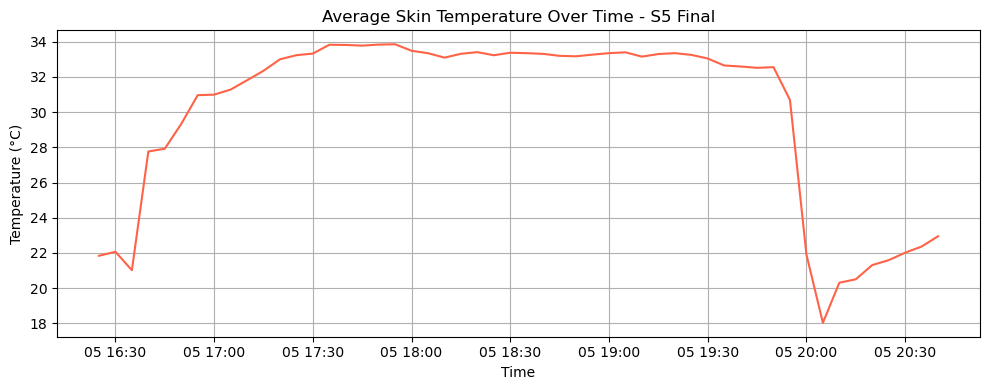

In [79]:
temp_df["timestamp_datetime"] = pd.to_datetime(temp_df["timestamp"], unit="s")

# Set timestamp as index
temp_df.set_index("timestamp_datetime", inplace=True)

# Resample: average temperature every 5 minutes (adjustable)
temp_avg = temp_df.groupby(["Subject", "Exam"]).resample("5min").mean().reset_index()

# Plot example: one subject and exam
example = temp_avg[(temp_avg["Subject"] == "S5") & (temp_avg["Exam"] == "Final")]

plt.figure(figsize=(10, 4))
plt.plot(example["timestamp_datetime"], example["value"], color="tomato")
plt.title("Average Skin Temperature Over Time - S5 Final")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
temp_df

,value,timestamp,Subject,Exam
timestamp_datetime,,,,
2018-12-05 16:28:54.000,21.71,1.544027e+09,S5,Final
2018-12-05 16:28:54.250,21.71,1.544027e+09,S5,Final
2018-12-05 16:28:54.500,21.71,1.544027e+09,S5,Final
2018-12-05 16:28:54.750,21.71,1.544027e+09,S5,Final
2018-12-05 16:28:55.000,21.71,1.544027e+09,S5,Final
...,...,...,...,...
2018-11-10 17:44:43.750,22.97,1.541872e+09,S9,Midterm 2
2018-11-10 17:44:44.000,22.97,1.541872e+09,S9,Midterm 2
2018-11-10 17:44:44.250,22.97,1.541872e+09,S9,Midterm 2


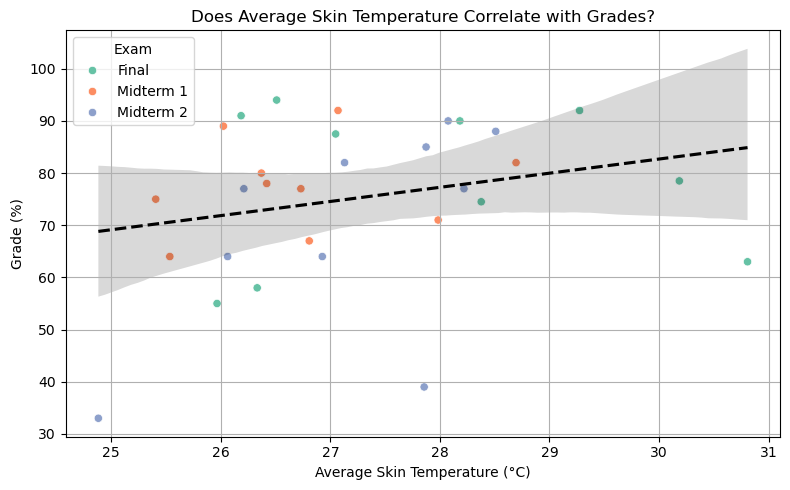

Correlation: 0.24752245144798957


In [81]:
temp_summary = (
    temp_df
    .reset_index()  
    .groupby(["Subject", "Exam"])["value"]
    .mean()
    .reset_index(name="AvgTemp")
)
merged_temp = temp_summary.merge(grades_df, on=["Subject", "Exam"])


plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_temp, x="AvgTemp", y="GradePercent", hue="Exam", palette="Set2")
sns.regplot(data=merged_temp, x="AvgTemp", y="GradePercent", scatter=False, color="black", line_kws={"linestyle":"--"})
plt.title("Does Average Skin Temperature Correlate with Grades?")
plt.xlabel("Average Skin Temperature (°C)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Correlation:", merged_temp["AvgTemp"].corr(merged_temp["GradePercent"]))

#### Electrodermal Activity

In [82]:
eda_df

,value,timestamp,Subject,Exam
0,0.000000,1.544027e+09,S5,Final
1,0.002562,1.544027e+09,S5,Final
2,0.020495,1.544027e+09,S5,Final
3,0.021776,1.544027e+09,S5,Final
4,0.019214,1.544027e+09,S5,Final
...,...,...,...,...
1773115,0.015375,1.541872e+09,S9,Midterm 2
1773116,0.014094,1.541872e+09,S9,Midterm 2
1773117,0.015375,1.541872e+09,S9,Midterm 2
1773118,0.014094,1.541872e+09,S9,Midterm 2


/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_50268/2329625435.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("5S")["value"]


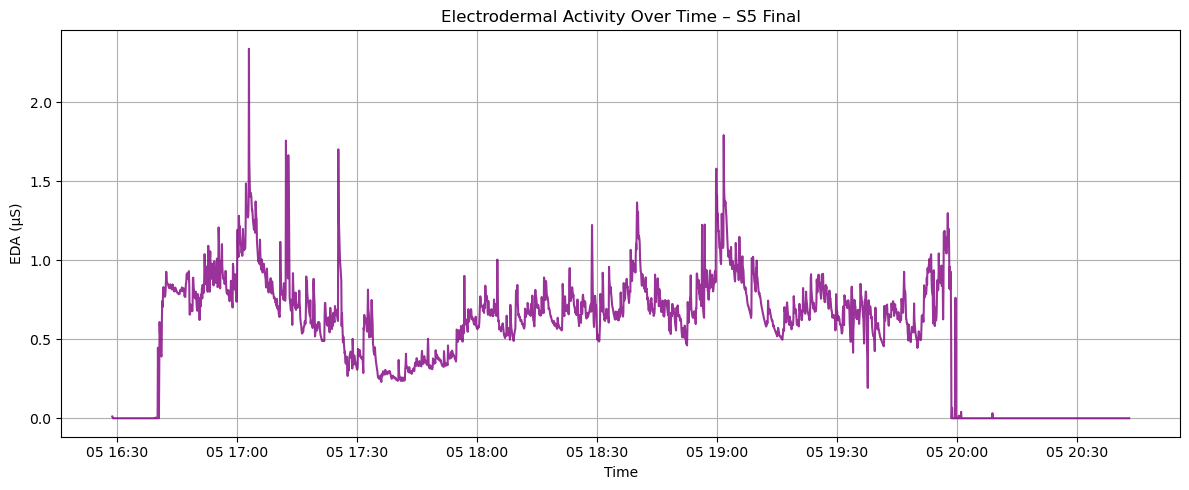

In [83]:

# Pick a student and exam
student = "S5"
exam = "Final"

# Filter the EDA data
eda_single = eda_df[(eda_df["Subject"] == student) & (eda_df["Exam"] == exam)].copy()

# Convert timestamp to datetime if needed
eda_single["timestamp"] = pd.to_datetime(eda_single["timestamp"], unit="s")

# Optional: Downsample for smoother plot (e.g., every 5 seconds)
eda_resampled = (
    eda_single.set_index("timestamp")
    .resample("5S")["value"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(eda_resampled["timestamp"], eda_resampled["value"], color="purple", alpha=0.8)
plt.title(f"Electrodermal Activity Over Time – {student} {exam}")
plt.xlabel("Time")
plt.ylabel("EDA (μS)")
plt.grid(True)
plt.tight_layout()
plt.show()

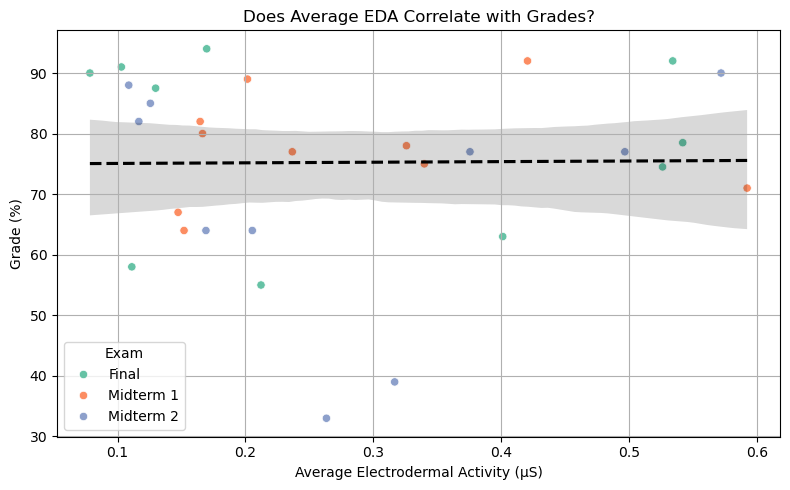

EDA ↔ Grade correlation: 0.011


In [84]:
eda_summary = (
    eda_df.groupby(["Subject", "Exam"])["value"]
    .mean()
    .reset_index(name="AvgEDA")
)

grades_df["Subject"] = grades_df["Subject"].apply(lambda s: f"S{int(s[1:])}")

eda_merged = eda_summary.merge(grades_df, on=["Subject", "Exam"])

plt.figure(figsize=(8, 5))
sns.scatterplot(data=eda_merged, x="AvgEDA", y="GradePercent", hue="Exam", palette="Set2")
sns.regplot(data=eda_merged, x="AvgEDA", y="GradePercent", scatter=False, color="black", line_kws={"linestyle": "--"})
plt.title("Does Average EDA Correlate with Grades?")
plt.xlabel("Average Electrodermal Activity (μS)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

corr = eda_merged["AvgEDA"].corr(eda_merged["GradePercent"])
print(f"EDA ↔ Grade correlation: {corr:.3f}")

#### Heart Rate

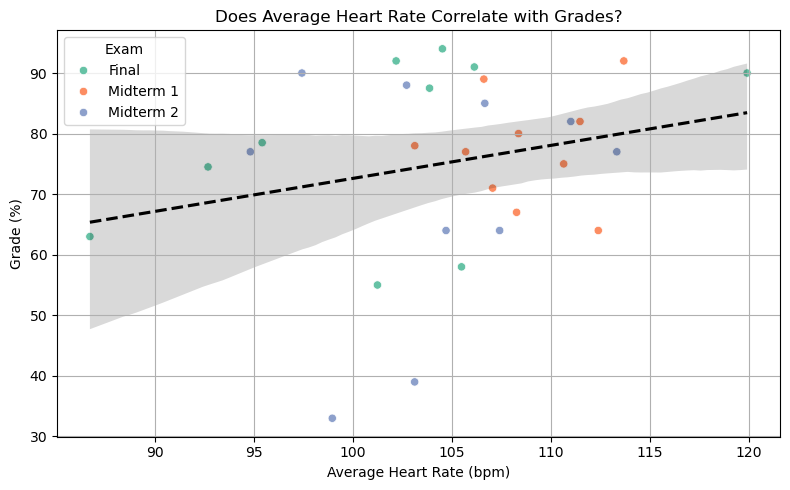

HR ↔ Grade correlation: 0.246


In [85]:
# Group by Subject and Exam to get average HR
hr_summary = (
    hr_df.groupby(["Subject", "Exam"])["value"]
    .mean()
    .reset_index(name="AvgHR")
)
# Ensure Subject format matches (e.g., S01 → S1)
grades_df["Subject"] = grades_df["Subject"].apply(lambda s: f"S{int(s[1:])}")

# Merge grades with avg HR
hr_merged = hr_summary.merge(grades_df, on=["Subject", "Exam"])


plt.figure(figsize=(8, 5))
sns.scatterplot(data=hr_merged, x="AvgHR", y="GradePercent", hue="Exam", palette="Set2")
sns.regplot(data=hr_merged, x="AvgHR", y="GradePercent", scatter=False, color="black", line_kws={"linestyle": "--"})
plt.title("Does Average Heart Rate Correlate with Grades?")
plt.xlabel("Average Heart Rate (bpm)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Compute Pearson correlation
corr = hr_merged["AvgHR"].corr(hr_merged["GradePercent"])
print(f"HR ↔ Grade correlation: {corr:.3f}")

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_50268/946371015.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("10S")["value"]


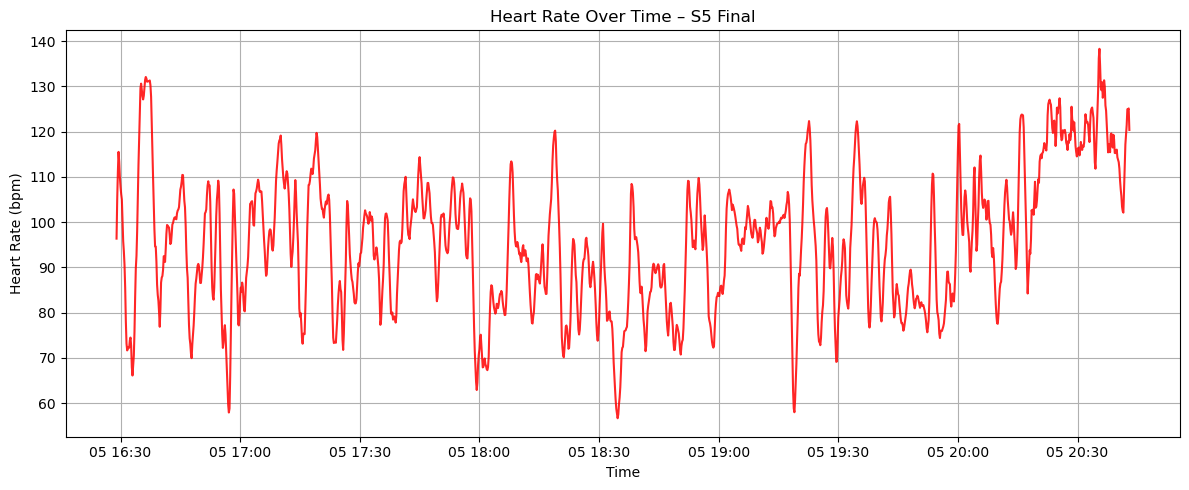

In [86]:

# Pick a student and exam
student = "S5"
exam = "Final"

# Filter the HR data
hr_single = hr_df[(hr_df["Subject"] == student) & (hr_df["Exam"] == exam)].copy()

# Convert UNIX timestamp to datetime
hr_single["timestamp"] = pd.to_datetime(hr_single["timestamp"], unit="s")

# Optional: resample to 10s intervals to smooth noise
hr_resampled = (
    hr_single.set_index("timestamp")
    .resample("10S")["value"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hr_resampled["timestamp"], hr_resampled["value"], color="red", alpha=0.85)
plt.title(f"Heart Rate Over Time – {student} {exam}")
plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Inter-Beat Interval

It refers to the time in seconds between consecutive heartbeats, measured from the peaks of successive heartbeats (often from the R-peaks in an ECG or from peaks in the BVP signal in wearables).

Shorter IBI → higher heart rate,
Longer IBI → lower heart rate.

BI is key for calculating Heart Rate Variability (HRV) — a measure of how much the time between heartbeats varies.

In [71]:
ibi_df

,offset,ibi_duration,timestamp,Subject,Exam
0,240.823524,1.734454,1.544028e+09,S5,Final
1,242.589229,1.765706,1.544028e+09,S5,Final
2,270.778019,0.937543,1.544028e+09,S5,Final
3,335.218469,0.515649,1.544028e+09,S5,Final
4,340.499961,0.453146,1.544028e+09,S5,Final
...,...,...,...,...,...
43899,7889.111120,0.750034,1.541867e+09,S9,Midterm 2
43900,7963.208262,0.609403,1.541867e+09,S9,Midterm 2
43901,8096.448735,0.765660,1.541868e+09,S9,Midterm 2
43902,8097.448781,1.000046,1.541868e+09,S9,Midterm 2


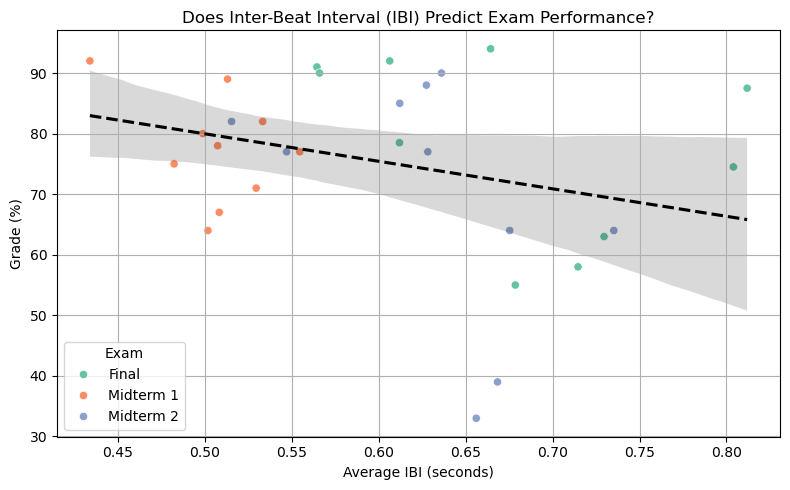

IBI ↔ Grade correlation: -0.288


In [72]:
# Calculate average IBI for each Subject and Exam
ibi_summary = (
    ibi_df.groupby(["Subject", "Exam"])["ibi_duration"]
    .mean()
    .reset_index(name="AvgIBI")
)

# Ensure Subject format matches (e.g., S01 → S1)
grades_df["Subject"] = grades_df["Subject"].apply(lambda s: f"S{int(s[1:])}")

# Merge
ibi_merged = ibi_summary.merge(grades_df, on=["Subject", "Exam"])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=ibi_merged, x="AvgIBI", y="GradePercent", hue="Exam", palette="Set2")
sns.regplot(data=ibi_merged, x="AvgIBI", y="GradePercent", scatter=False, color="black", line_kws={"linestyle": "--"})
plt.title("Does Inter-Beat Interval (IBI) Predict Exam Performance?")
plt.xlabel("Average IBI (seconds)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Pearson correlation
corr = ibi_merged["AvgIBI"].corr(ibi_merged["GradePercent"])
print(f"IBI ↔ Grade correlation: {corr:.3f}")

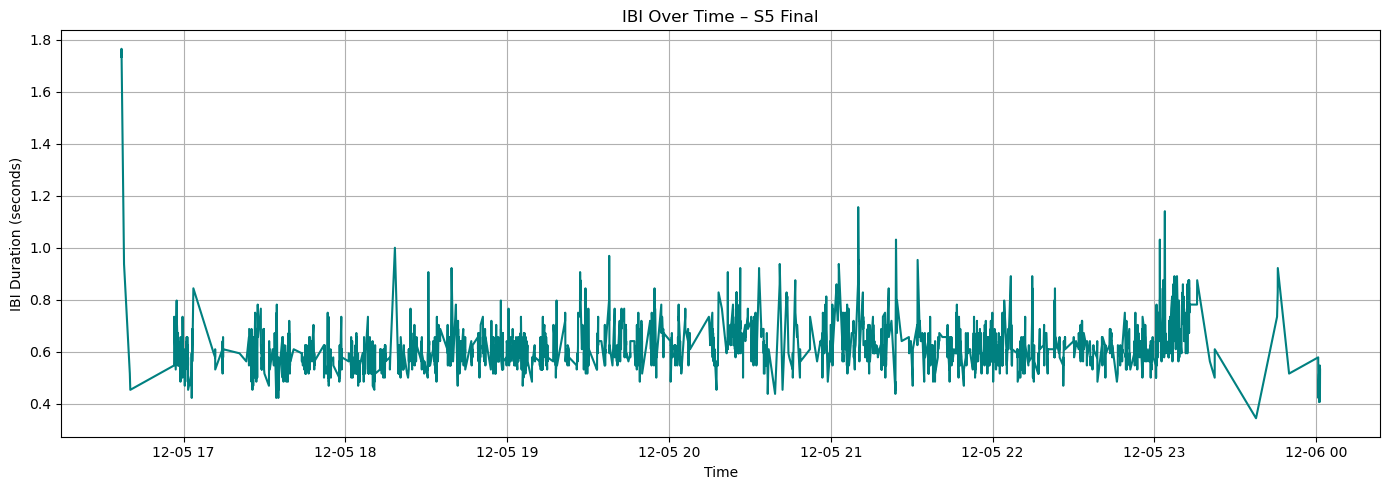

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter for one student and exam
ibi_filtered = ibi_df[(ibi_df['Subject'] == 'S5') & (ibi_df['Exam'] == 'Final')].copy()

# Create a datetime column by adding offset (in seconds) to the exam start time
ibi_filtered["timestamp_datetime"] = pd.to_datetime(ibi_filtered["timestamp"] + ibi_filtered["offset"], unit="s")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(ibi_filtered["timestamp_datetime"], ibi_filtered["ibi_duration"], color='teal')
plt.title("IBI Over Time – S5 Final")
plt.xlabel("Time")
plt.ylabel("IBI Duration (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Accelerometer

ACC_X, ACC_Y, ACC_Z: Measure acceleration in the X, Y, and Z directions.
	•	Values are in units of 1/64 g, where g ≈ 9.81 m/s² (Earth’s gravity).
	•	The Empatica E4 device records these at a high frequency (32 Hz).

In [91]:
acc_df["timestamp_datetime"] = pd.to_datetime(acc_df["timestamp"], unit="s")
acc_df

,ACC_X,ACC_Y,ACC_Z,timestamp,Subject,Exam,magnitude,timestamp_datetime
timestamp_datetime,,,,,,,,
2018-12-05 16:28:54.000000,-2,-63,6,1.544027e+09,S5,Final,63.316664,2018-12-05 16:28:54.000000
2018-12-05 16:28:54.031250,-2,-62,6,1.544027e+09,S5,Final,62.321746,2018-12-05 16:28:54.031250
2018-12-05 16:28:54.062500,-2,-63,7,1.544027e+09,S5,Final,63.419240,2018-12-05 16:28:54.062500
2018-12-05 16:28:54.093750,-2,-62,6,1.544027e+09,S5,Final,62.321746,2018-12-05 16:28:54.093750
2018-12-05 16:28:54.125000,-2,-62,6,1.544027e+09,S5,Final,62.321746,2018-12-05 16:28:54.125000
...,...,...,...,...,...,...,...,...
2018-11-10 17:44:46.468750,16,-20,60,1.541872e+09,S9,Midterm 2,65.238026,2018-11-10 17:44:46.468750
2018-11-10 17:44:46.500000,16,-20,60,1.541872e+09,S9,Midterm 2,65.238026,2018-11-10 17:44:46.500000
2018-11-10 17:44:46.531250,17,-17,59,1.541872e+09,S9,Midterm 2,63.710282,2018-11-10 17:44:46.531250


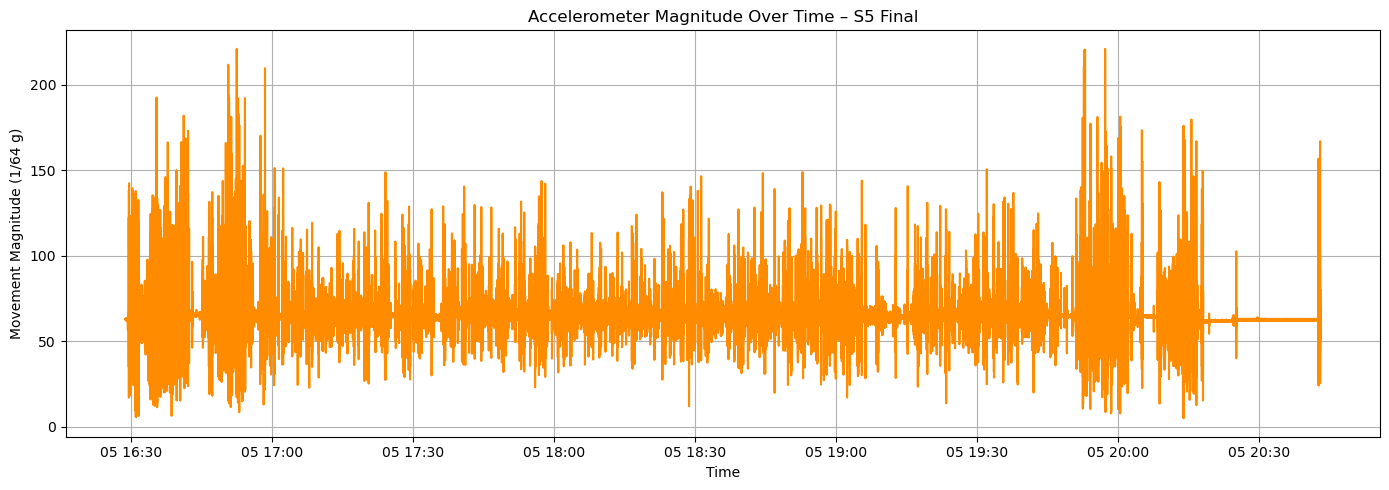

In [92]:
# Filter for one session
single = acc_df[(acc_df["Subject"] == "S5") & (acc_df["Exam"] == "Final")]

# Plot
plt.figure(figsize=(14,5))
plt.plot(single["timestamp_datetime"], single["magnitude"], color='darkorange')
plt.title("Accelerometer Magnitude Over Time – S5 Final")
plt.xlabel("Time")
plt.ylabel("Movement Magnitude (1/64 g)")
plt.grid(True)
plt.tight_layout()
plt.show()

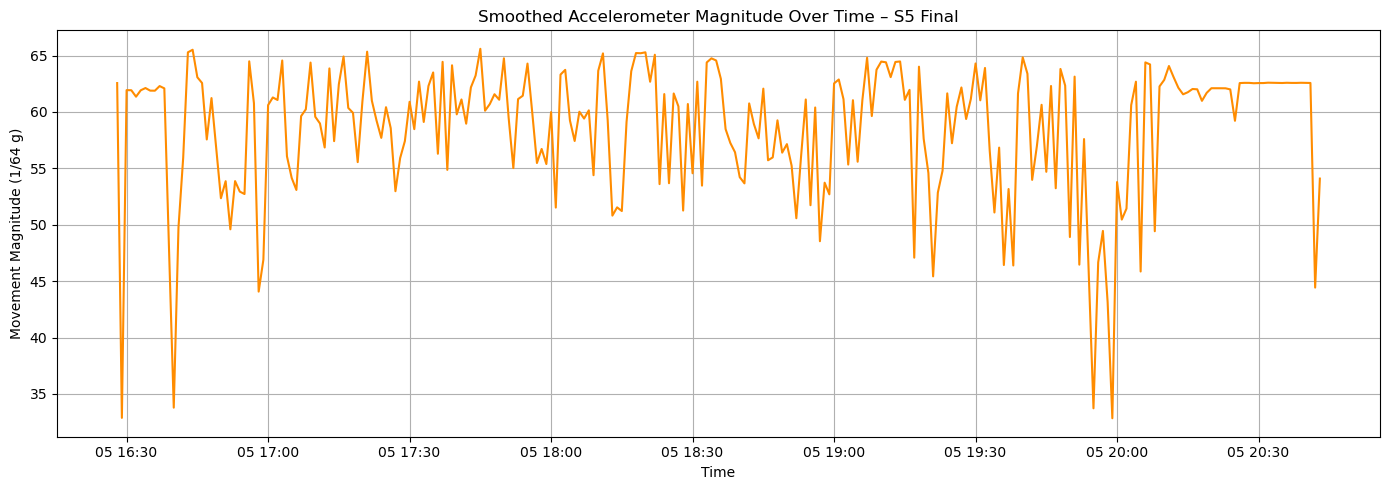

In [94]:
# Convert timestamp and set index
acc_df["timestamp_datetime"] = pd.to_datetime(acc_df["timestamp"], unit="s")
acc_df.set_index("timestamp_datetime", inplace=True)

# Filter for just S5 Final
acc_s5_final = acc_df[(acc_df["Subject"] == "S5") & (acc_df["Exam"] == "Final")]

# Keep only numeric columns for resampling
acc_s5_final_numeric = acc_s5_final[["ACC_X", "ACC_Y", "ACC_Z"]]

# Resample and take the mean every 1 minute
acc_resampled = acc_s5_final_numeric.resample("1min").mean()

# Compute magnitude of movement
acc_resampled["magnitude"] = np.sqrt(
    acc_resampled["ACC_X"]**2 + acc_resampled["ACC_Y"]**2 + acc_resampled["ACC_Z"]**2
)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(acc_resampled.index, acc_resampled["magnitude"], color='darkorange')
plt.title("Smoothed Accelerometer Magnitude Over Time – S5 Final")
plt.xlabel("Time")
plt.ylabel("Movement Magnitude (1/64 g)")
plt.grid(True)
plt.tight_layout()
plt.show()

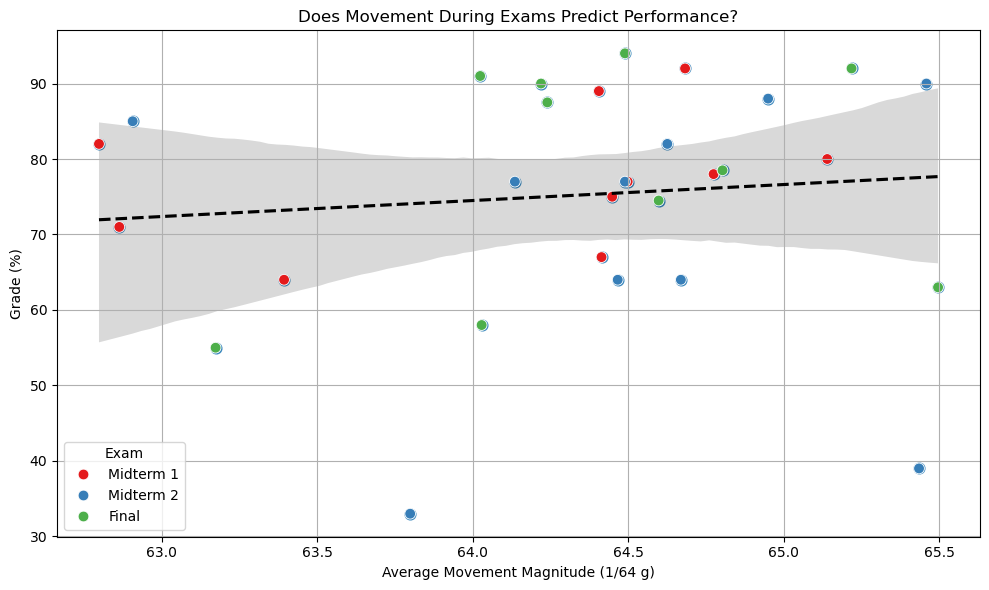

In [95]:
# 2. Average per subject/exam
movement_summary = acc_df.groupby(["Subject", "Exam"])["magnitude"].mean().reset_index()
movement_summary.rename(columns={"magnitude": "AvgMovement"}, inplace=True)

# 3. Merge with grades
movement_grades = pd.merge(grades_df, movement_summary, on=["Subject", "Exam"])

# 4. Plot
plt.figure(figsize=(10, 6))
sns.regplot(data=movement_grades, x="AvgMovement", y="GradePercent", scatter_kws={"s": 60}, line_kws={"color": "black", "linestyle": "--"})
sns.scatterplot(data=movement_grades, x="AvgMovement", y="GradePercent", hue="Exam", palette="Set1", s=60, legend=True)

plt.title("Does Movement During Exams Predict Performance?")
plt.xlabel("Average Movement Magnitude (1/64 g)")
plt.ylabel("Grade (%)")
plt.grid(True)
plt.tight_layout()
plt.show()